# Fugu Example Notebook - Fibonacci Sequence

Brad Aimone, 3/14/2022.  Happy Pi Day.

This notebook shows how Fugu can be used to generate more complex arithmetic circuits from  basic streaming arithmetic functions such as addition.  The goal of this notebook is to show how more complex arithemetic fucntinos can be simply composed from Fugu bricks.


## Step 0: Setup
First, we need to import Fugu and other relevant libraries.  Here, we will include the adder bricks

In [1]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend
from fugu.bricks import streaming_adder, temporal_shift

In [14]:
#A function to plot spike rasters:
def plot_spike_raster(scaffold, results):
    import matplotlib.pyplot as plot
    num_elements=scaffold.graph.number_of_nodes()
    print('Number of neurons: ', num_elements)
    results.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
    plot.show()
    
#A function to compute the value from LEIT coded neurons
def compute_value(result):
    for i in range(0,8):
        add_element=12+9*i
        last_adder_begin=np.sum(result.query('neuron_number=='+str(add_element)+'-6')['time'])
        query_str=str(last_adder_begin)+' <= time and neuron_number ==' +str(add_element-1)
        f10=np.sum(2**(result.query(query_str)['time']-last_adder_begin))
        print('Fibonacci ' + str(i+3) + ' '+ str(f10) +' at neuron ' + str(add_element-1))

## Example: Brute force circuit

The goal of this circuit is to implement the Fibonacci sequence by brute force; if we want to go 10 layers, we will have 10 adders.  

First we instantiate an empty scaffold, and we prep some input data.

The input data might seem strange; The examples in this notebook describe circuits that use inputs which are encoded using a little-endian-in-time (LEIT) coding scheme.  LEIT coding is simple - think of a binary description of a number (19 = 10011), flip it around so the least significant bit is first (19 => 11001), and then have the input neuron spike at the first, second, and fifth timesteps. 

In [3]:
scaffold = Scaffold()

#Input values
F_1=[0,0]
F_2=[1,0]
shift_length_total = 2


We'll now add input bricks to represent the first and second values.  We add a brick to a scaffold like this:

`scaffold.add_brick(brick_function, input_nodes=[], metadata=None, name=None, output=False)`

- `brick_function` is the brick itself.
- `input_nodes` is a list of inputs nodes.  In this case, they are inputs so we have the special case of 'input', or equivalently ['input'].
- `metadata` is used to include extra information about a node.  Previously this had some functionality, but now is mostly just for taking notes and is usually unused.
- `ouput` set to `True` if this is an output for the network.  Generally, only output bricks are recorded.

We use `Vector_Input` as our input brick type.  This type of input brick is useful for loading a numpy array (or anything that can be cast to a numpy array) as a spike train.

Creating a `Vector_Input` looks like this:

`Vector_Input(spikes, time_dimension = False, coding='Undefined', batchable=True, name='VectorInput')`

- `spikes` array of spikes
- `time_dimension` if True, the input array's 0-th dimension is treated as a time dimension. All other dimensions are treated as spatial dimensions.
- `coding` choose a Coding type.  As this is an input, the coding type is self-reported.
- `batchable` set to `True` if input should represent static data; currently `True` is the only supported mode.
- `name` set the name of the brick.  If not specified, a default will be used.  Name should be unique.

In [4]:
scaffold.add_brick(Vector_Input(np.array([F_1]), coding='binary-L', name='F1', time_dimension=True), 'input') #0
scaffold.add_brick(Vector_Input(np.array([F_2]), coding='binary-L', name='F2', time_dimension=True), 'input') #1

Our scaffold is defined, but so far it only has inputs.  We need to compute the intermediate sums, we'll add some adders.

In [5]:
# The first adder will add of F1 and F2.  This output is F3
scaffold.add_brick(streaming_adder(name='add_12_'), [(0,0), (1,0)], output=True) #2

What's going on with this statement? We are adding a brick as before except:

- `streaming_adder` only needs a name; we call it "add_12_"
- `[(0,0), (1,0)]` says that we're connecting it to Node 0, Output 0 (F1) and Node 1, Output 0 (F2)
- `output` being `True` means that we'll record from this brick

There are other ways to specify the input connections.  We have tried to be flexible to support what formats are convenient.  Please check the documentation and/or the code for options.

Generally, recording from intermediate bricks is discouraged because it can slow processing and require more resources.

Let's take a second to look at what's going on in the scaffold.

False
None


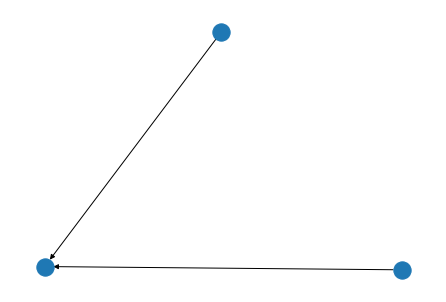

In [6]:
print(scaffold.is_built)  #Scaffold has not been built
print(scaffold.graph) #So the graph is None

nx.draw(scaffold.circuit) #But we can draw the circuit


In [7]:
scaffold.summary()  #We can also get a text summary

Scaffold is built: False
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: F1-0
Brick Name: F1
{'tag': 'F1-0', 'name': 'F1', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f388da6d970>, 'layer': 'input', 'input_nodes': [(-2, 0)]}
Brick is built: False


Brick No.: 1
Brick Tag: F2-1
Brick Name: F2
{'tag': 'F2-1', 'name': 'F2', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7f388da6dd00>, 'layer': 'input', 'input_nodes': [(-2, 0)]}
Brick is built: False


Brick No.: 2
Brick Tag: Brick-2
Brick Name: add_12_
{'tag': 'Brick-2', 'name': 'add_12_', 'brick': <fugu.bricks.adder_bricks.streaming_adder object at 0x7f388da6d580>, 'input_nodes': [(0, 0), (1, 0)], 'layer': 'output'}
Brick is built: False


-------------------------------------------------------


-------------------------------------------------------
List of Brick Edges:


Edge: (0, 2)
{}
Edge: (1, 2)
{}


Let's repeat the process to build more sums.  We could've (and should've) use a for loop for this.

One thing to note, bricks transfer spikes to the next brick as soon as possible.  

In this example, that matters because (for example):
`F1 + F2 = F3` (via brick `add_12_` )

`F2 + F3 = F4` (via brick `add_23_` )

But `F2` will send its spikes to `add_23_` as soon as they are available.  But, `add_12_` takes time to compute.  It takes precisely 2 timesteps.  So, we add an additional brick, `temporal_shift` to delay the spikes from `F2`.  This way all the information arrives at `add_23_` at the same time. 

In [8]:
# The second adder adds a time-delayed version (2 timesteps) of F2 and F3.  This output is F4
scaffold.add_brick(temporal_shift(name='shift_2_', shift_length=shift_length_total), [(1,0)], output=True) #3
scaffold.add_brick(streaming_adder(name='add_23_'), [(2,0), (3,0)], output=True)

# The third adder adds a time-delayed version of F3 and F4.  This output is F5
scaffold.add_brick(temporal_shift(name='shift_3_', shift_length=shift_length_total), [(2,0)], output=True) #5
scaffold.add_brick(streaming_adder(name='add_34_'), [(4,0), (5,0)], output=True)

# The fourth adder adds a time-delayed version of F4 and F5.  This output is F6
scaffold.add_brick(temporal_shift(name='shift_4_', shift_length=shift_length_total), [(4,0)], output=True) #7
scaffold.add_brick(streaming_adder(name='add_45_'), [(6,0), (7,0)], output=True)

# and so forth.  We'll do this for 10 elements
scaffold.add_brick(temporal_shift(name='shift_5_', shift_length=shift_length_total), [(6,0)], output=True) #9
scaffold.add_brick(streaming_adder(name='add_56_'), [(8,0), (9,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_6_', shift_length=shift_length_total), [(8,0)], output=True) #11
scaffold.add_brick(streaming_adder(name='add_67_'), [(10,0), (11,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_7_', shift_length=shift_length_total), [(10,0)], output=True) #13
scaffold.add_brick(streaming_adder(name='add_78_'), [(12,0), (13,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_8_', shift_length=shift_length_total), [(12,0)], output=True) #15
scaffold.add_brick(streaming_adder(name='add_89_'), [(14,0), (15,0)], output=True)

scaffold.add_brick(temporal_shift(name='shift_9_', shift_length=shift_length_total), [(14,0)], output=True) #17
scaffold.add_brick(streaming_adder(name='add_910_'), [(16,0), (17,0)], output=True) 


We now see our circuit is much more interesting.

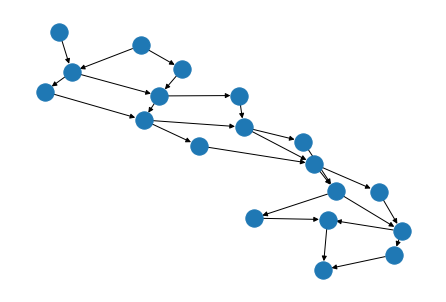

In [9]:
nx.draw(scaffold.circuit)

In [11]:
#Lastly, lay_bricks builds an IR
scaffold.lay_bricks()

We now have a built scaffold.graph!

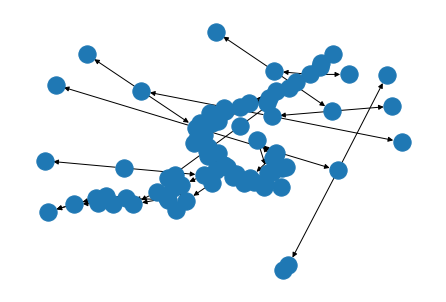

In [12]:
nx.draw(scaffold.graph)

It's time to run our scaffold.  For that, we need a backend.  We'll use the snn simulator backend.  

In [13]:
backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend.compile(scaffold, backend_args)
result = backend.run(50)
print(result)

     time  neuron_number
0     0.0            5.0
1     0.0            0.0
2     0.0            3.0
3     1.0            1.0
4     1.0            4.0
..    ...            ...
108  22.0           80.0
109  23.0           83.0
110  24.0           76.0
111  25.0           70.0
112  28.0           79.0

[113 rows x 2 columns]


Lastly, we can print and plot our results.

Number of neurons:  84


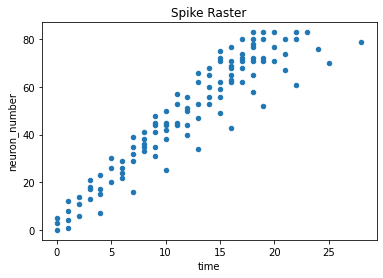

In [12]:
plot_spike_raster(scaffold, result)

In [15]:
compute_value(result)

Fibonacci 3 1.0 at neuron 11
Fibonacci 4 2.0 at neuron 20
Fibonacci 5 3.0 at neuron 29
Fibonacci 6 5.0 at neuron 38
Fibonacci 7 8.0 at neuron 47
Fibonacci 8 13.0 at neuron 56
Fibonacci 9 21.0 at neuron 65
Fibonacci 10 34.0 at neuron 74


### For more details and a recursive example, see `Fibonacci_example.ipynb` on the Fugu repo.